import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset_padding4cls import *
from utils.network_arch_cls import *
from utils.trainval_cls_withMasking import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step008_clsGTMaskPadNoRej_P004_res34_wSqrtInvFreq' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:1'
print(device)

freqShow = 100

#model parameters
batch_size = 8
newSize = [512, 512]
total_epoch_num = 300  # total number of epoch in training
base_lr = 0.0001      # base learning rate/


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:1


In [3]:
with open('dbinfo_cls_noRejectClass.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)


cls_datasets = {set_name: PollenCls(dbinfo, size=newSize, set_name=set_name, maskType='grnd')
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

32060 4535


In [4]:
data_sampler = iter(dataloaders['train'])

In [5]:
data = next(data_sampler)
image, segMask, label = data

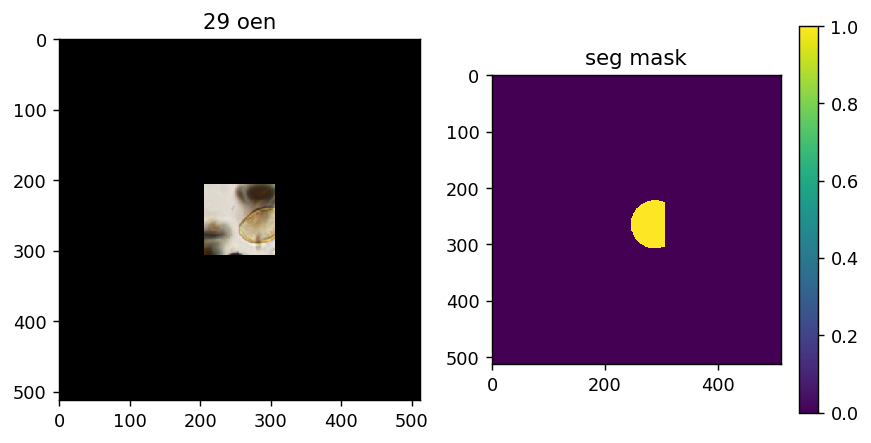

In [6]:
idx = 7
tmplabel = label[idx].squeeze().cpu().detach().numpy()
tmplabel = round(tmplabel.item())
labelName = dbinfo['meta'][tmplabel-1]


numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(8, 4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('{:02d} '.format(tmplabel)+labelName)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = segMask[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')
plt.colorbar()

In [7]:
max(dbinfo['perClassCount']), min(dbinfo['perClassCount'])
perClsWeight = np.asarray(dbinfo['perClassCount'], dtype=np.float32) + 1
perClsWeight = np.sqrt(perClsWeight)
perClsWeight = 1/perClsWeight
perClsWeight = torch.from_numpy(perClsWeight).view(-1) * 250

Text(0, 0.5, 'number in train set')

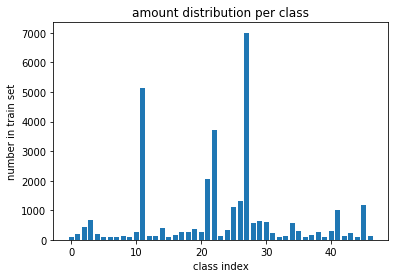

In [8]:
plt.bar(list(range(47)), dbinfo['perClassCount'])
plt.title('amount distribution per class')
plt.xlabel('class index')
plt.ylabel('number in train set')

In [13]:
################## init model ###################

initModel = PollenClsNet(34, nClass=47, pretrained=True, poolSize=16)

initModel.to(device);

using pretrained model


In [14]:
image = image.to(device)
label = label.type(torch.long).view(-1).to(device)
outputs = initModel(image)

In [15]:
#lossFunc_cls = nn.CrossEntropyLoss()
perClsWeight = perClsWeight.to(device)
lossFunc_cls = nn.CrossEntropyLoss(weight=perClsWeight)

In [16]:
loss = lossFunc_cls(outputs, label.squeeze(-1).squeeze(-1))

In [17]:
optimizer = optim.Adam([{'params': initModel.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

In [18]:
################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [ ]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_cls, optimizer, exp_lr_scheduler,                       
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, device=device, freqShow=freqShow)


Epoch 1/300
----------
train
	100/4008 loss:4.362
	200/4008 loss:4.113
	300/4008 loss:3.897
	400/4008 loss:3.782
	500/4008 loss:3.686
	600/4008 loss:3.623
	700/4008 loss:3.566
	800/4008 loss:3.493
	900/4008 loss:3.449
	1000/4008 loss:3.408
	1100/4008 loss:3.364
	1200/4008 loss:3.320
	1300/4008 loss:3.269
	1400/4008 loss:3.231
	1500/4008 loss:3.194
	1600/4008 loss:3.159
	1700/4008 loss:3.129
	1800/4008 loss:3.100
	1900/4008 loss:3.068
	2000/4008 loss:3.040
	2100/4008 loss:3.025
	2200/4008 loss:2.999
	2300/4008 loss:2.978
	2400/4008 loss:2.957
	2500/4008 loss:2.940
	2600/4008 loss:2.918
	2700/4008 loss:2.899
	2800/4008 loss:2.881
	2900/4008 loss:2.867
	3000/4008 loss:2.849
	3100/4008 loss:2.831
	3200/4008 loss:2.815




Leaving Blank
-----